In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
def loadImages(data_path, size=(200,150)):
     x = []
     t = []
     classes = os.listdir(data_path)
     for ic in range(len(classes)):
          filenames = os.listdir(f"{data_path}/{classes[ic]}")
          for ifile in range(len(filenames)):
               filename = f"{data_path}/{classes[ic]}/{filenames[ifile]}"
               print(f"\rload {filename:<100} ... {ifile+1}/{len(filenames):^10}",end=" "*100)
               image = cv2.imread(filename)
               image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
               image = cv2.resize(image, size)/255
               # image = np.dstack([image])
               x.append(image)
               t.append(ic)
     x = np.array(x, dtype=np.float32)
     t = np.array(t, dtype=np.float32)
     return x, t

In [3]:
# set parameters
data_path = "../data/Split_New_InTheWildFaces"
save_data = "data_loaded.mat"
model_filename = "../models/model_150x200.h5"

In [4]:
# load images
x_train, t_train = loadImages(f"{data_path}/train")
x_val, t_val = loadImages(f"{data_path}/val")
x_test, t_test = loadImages(f"{data_path}/test")
print(f"train size",x_train.shape, t_train.shape)
print(f"val size",x_val.shape, t_val.shape)
print(f"test size",x_test.shape, t_test.shape)

load ../data/Split_New_InTheWildFaces/test/1/60_1_2_20170110151419801.jpg                                 ... 1033/   1033                                                                                                       train size (9319, 150, 200, 3) (9319,)
val size (1968, 150, 200, 3) (1968,)
test size (2083, 150, 200, 3) (2083,)


In [5]:
print(f"train size",x_train.shape, t_train.shape)

train size (9319, 150, 200, 3) (9319,)


In [6]:
# model structure
model = tf.keras.Sequential([
     tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu',input_shape=(150, 200, 3)),
     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
     tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
     tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D(pool_size=(5,5)),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation='relu'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(2 ,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 100, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 33, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 33, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 6, 64)         0

In [7]:
model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_filename, monitor='val_loss', mode='min', verbose=1, save_best_only=True)


In [8]:
# training
model.fit(x_train, t_train, validation_data=(x_val, t_val), callbacks=[es,mc], epochs=100000)

Epoch 1/100000
292/292 [==============================] - ETA: 0s - loss: 0.4612 - accuracy: 0.7800
Epoch 1: val_loss improved from inf to 0.29932, saving model to ../models\model_150x200.h5
292/292 [==============================] - 88s 298ms/step - loss: 0.4612 - accuracy: 0.7800 - val_loss: 0.2993 - val_accuracy: 0.8674
Epoch 2/100000
292/292 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.8854
Epoch 2: val_loss improved from 0.29932 to 0.23671, saving model to ../models\model_150x200.h5
292/292 [==============================] - 86s 295ms/step - loss: 0.2848 - accuracy: 0.8854 - val_loss: 0.2367 - val_accuracy: 0.9024
Epoch 3/100000
292/292 [==============================] - ETA: 0s - loss: 0.2270 - accuracy: 0.9086
Epoch 3: val_loss improved from 0.23671 to 0.19887, saving model to ../models\model_150x200.h5
292/292 [==============================] - 88s 303ms/step - loss: 0.2270 - accuracy: 0.9086 - val_loss: 0.1989 - val_accuracy: 0.9192
Epoch 4/100000
29

In [5]:
model = tf.keras.models.load_model("../models/model_150x200.h5")

: 

In [10]:
train_predicts = model.predict(x_train)
train_predicts = np.argmax(train_predicts, axis=1)

292/292 [==============================] - 19s 65ms/step


In [11]:
test_predicts = model.predict(x_test)
test_predicts = np.argmax(test_predicts, axis=1)

66/66 [==============================] - 4s 63ms/step


In [12]:
val_predicts = model.predict(x_val)
val_predicts = np.argmax(val_predicts, axis=1)

62/62 [==============================] - 4s 64ms/step


In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def graphConfusionMatrix(y_trues , y_predicts):
     class_names = ['Male', 'Female']

     cm = confusion_matrix(y_true=y_trues, y_pred=y_predicts).T

     plt.rcParams.update({'font.size': 10})
     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
     fig, ax = plt.subplots(figsize=(4, 4))
     disp.plot(ax=ax, cmap=plt.cm.Blues)
     plt.xlabel('Actuals', fontsize=10)
     plt.ylabel('Predictions', fontsize=10)
     plt.xticks(fontsize=10, rotation=45)
     plt.yticks(fontsize=10)
     plt.title('Confusion Matrix from model', fontsize=12)
     plt.show()

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97      4693
         1.0       0.97      0.98      0.97      4626

    accuracy                           0.97      9319
   macro avg       0.97      0.97      0.97      9319
weighted avg       0.97      0.97      0.97      9319



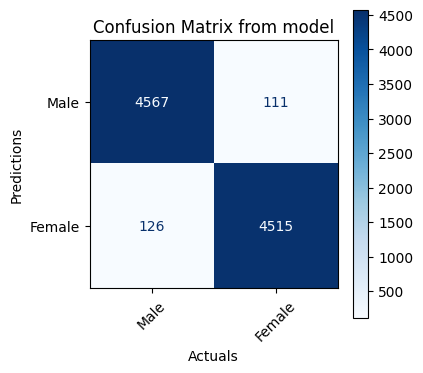

In [14]:
print(classification_report(t_train, train_predicts))
graphConfusionMatrix(t_train , train_predicts)

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      1050
         1.0       0.94      0.94      0.94      1033

    accuracy                           0.94      2083
   macro avg       0.94      0.94      0.94      2083
weighted avg       0.94      0.94      0.94      2083



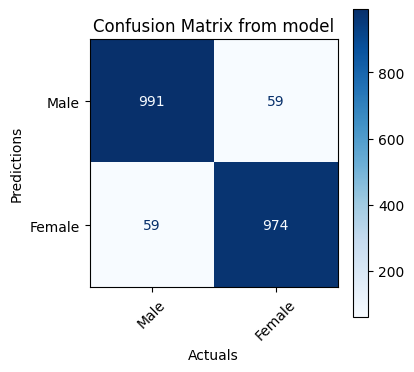

In [15]:
print(classification_report(t_test, test_predicts))
graphConfusionMatrix(t_test , test_predicts)

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95       991
         1.0       0.95      0.94      0.94       977

    accuracy                           0.95      1968
   macro avg       0.95      0.95      0.95      1968
weighted avg       0.95      0.95      0.95      1968



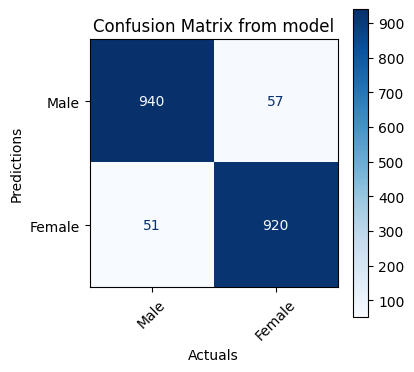

In [16]:
print(classification_report(t_val, val_predicts))
graphConfusionMatrix(t_val , val_predicts)